### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки и условия сдачи:
Дедлайн: сдать проект нужно в течение 72 часов после начала Урока 10 ("Вебинар. Консультация по итоговому проекту").
Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 должен быть больше 0.6.
При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата.
Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.
В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

#### Подключение библиотек и скриптов

In [981]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [982]:
import warnings
warnings.filterwarnings('ignore')

In [983]:
matplotlib.rcParams.update({'font.size': 14})

In [984]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пути к директориям и файлам

In [985]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [986]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
9995    77          32    2.0  50.401785   30.476203            5.0      6   
9996  6159          18    1.0  41.521546   20.539216            9.0     13   
9997  5123          27    1.0  47.939008         NaN            1.0     12   
9998  5400          75    2.0  43.602562   33.840147            8.0      1   
9999  6306         128    1.0  38.666645   21.157874            8.0      7   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9995         5.0       1968   0.135650         B         B        46   
9996        13.0       2000   0.000000         B         B        30   
9997        16.0       2015   0.072158         B         B         2   
9998         5.0       1961   0.307467         B         A        30   
9999        17.0       1990   0.000000         B         B        27   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
9995      7960         6         350.0            3       11       B   
9996      5562         0           NaN            0        5       A   
9997       629         1           NaN            0        0       A   
9998      5048         9         325.0            2        5       B   
9999      4798         0          30.0            2        8       B   

              Price  
9995  196684.316040  
9996  189050.289571  
9997  159143.805370  
9998  181595.339808  
9999  218714.077615

In [987]:
test_df = pd.read_csv(TEST_PATH)
test_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4995   8180          11    3.0  67.133911   50.809797            6.0      5   
4996   4695           1    1.0  40.198472   21.807061           10.0     12   
4997   5783          12    3.0  77.842178   48.282625            9.0     23   
4998   4780          62    2.0  81.305222         NaN            0.0      4   
4999  12504          30    2.0  60.555693         NaN            1.0     10   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4995         9.0       1973   0.000170         B         B        36   
4996        17.0       2017   0.007122         B         B         1   
4997        22.0       1989   0.090799         B         B        74   
4998         0.0       1977   0.072158         B         B         2   
4999        17.0       1977   0.000078         B         B        22   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
4995      5992         0           NaN            1        1       B  
4996       264         0           NaN            0        1       B  
4997     19083         2           NaN            5       15       B  
4998       629         1           NaN            0        0       A  
4999      6398       141        1046.0            3       23       B

In [988]:
train_df.shape[1]-1 == test_df.shape[1]

True

### Приведение типов данных

In [989]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [990]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [991]:
test_df['Id'] = train_df['Id'].astype(str)
test_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Обзор данных

**Целевая переменная**

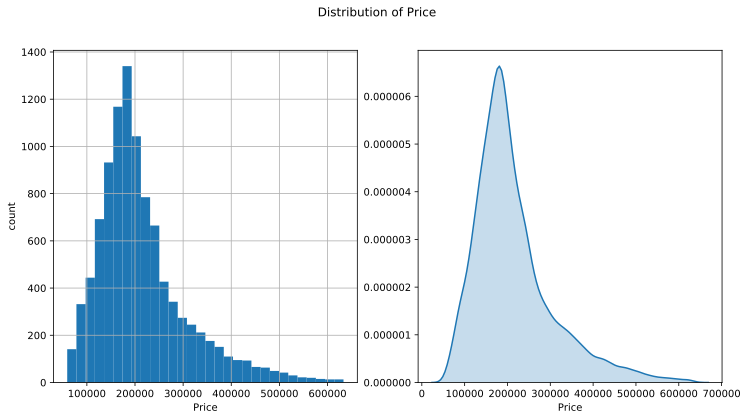

In [992]:
matplotlib.rcParams.update({'font.size': 10})
plt.style.use('default')
plt.figure(figsize = (12, 6))

plt.subplot(121)
train_df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [993]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = round(train_df['Price'].median(),2)

target_mean, target_median

(214138.86, 192269.64)

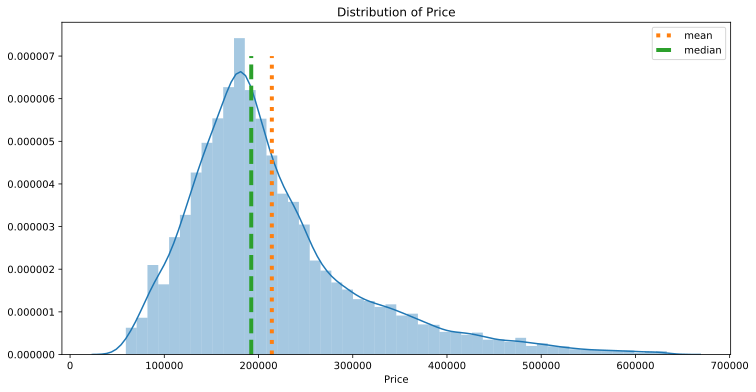

In [994]:
plt.figure(figsize = (12, 6))

sns.distplot(train_df['Price'])

y = np.linspace(0, 0.000007, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

**Количественные переменные**

In [995]:
train_df.describe()

Rooms        Square   LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  7887.000000   10000.000000  10000.000000   
mean       1.890500     56.315775    37.199645       6.273300      8.526700   
std        0.839512     21.058732    86.241209      28.560917      5.241148   
min        0.000000      1.136859     0.370619       0.000000      1.000000   
25%        1.000000     41.774881    22.769832       1.000000      4.000000   
50%        2.000000     52.513310    32.781260       6.000000      7.000000   
75%        2.000000     65.900625    45.128803       9.000000     12.000000   
max       19.000000    641.065193  7480.592129    2014.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000   5202.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1142.904460      1.319500      4.231300  214138.857399  
std       23.831875   1021.517264      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    350.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000   1548.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

**Категориальные переменные**

In [996]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [997]:
train_df.describe(include=['object'])

Id DistrictId Ecology_2 Ecology_3 Shops_2
count   10000      10000     10000     10000   10000
unique  10000        205         2         2       2
top      3431         27         B         B       B
freq        1        851      9903      9725    9175

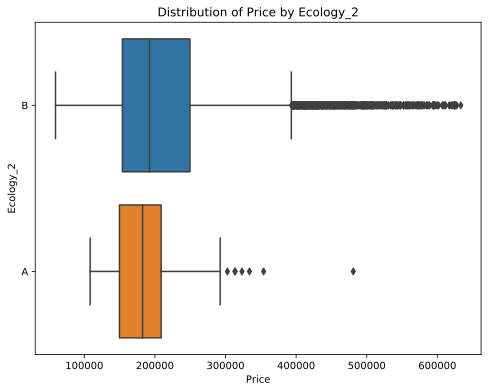

In [998]:
plt.figure(figsize=(8, 6))

sns.boxplot(train_df['Price'], train_df['Ecology_2'])

plt.xlabel('Price')
plt.ylabel('Ecology_2')
plt.title('Distribution of Price by Ecology_2')
plt.show()

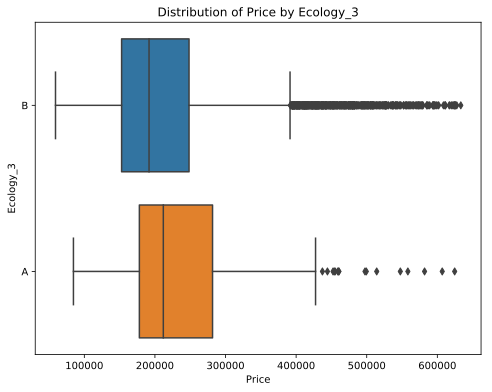

In [999]:
plt.figure(figsize=(8, 6))

sns.boxplot(train_df['Price'], train_df['Ecology_3'])

plt.xlabel('Price')
plt.ylabel('Ecology_3')
plt.title('Distribution of Price by Ecology_3')
plt.show()

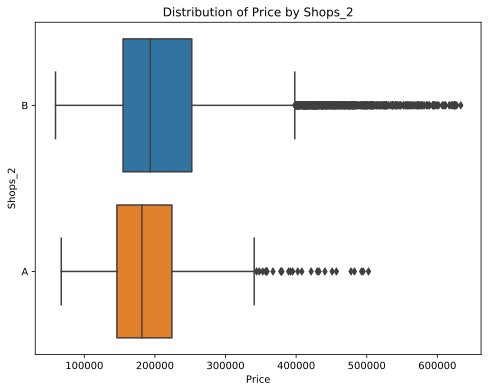

In [1000]:
plt.figure(figsize=(8, 6))

sns.boxplot(train_df['Price'], train_df['Shops_2'])

plt.xlabel('Price')
plt.ylabel('Shops_2')
plt.title('Distribution of Price by Shops_2')
plt.show()

### Обработка выбросов:

**Rooms**

In [1001]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [1002]:
train_df.loc[(train_df['Rooms'] > 5) | (train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].median()

In [1003]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [1004]:
test_df.loc[(test_df['Rooms'] > 5) | (test_df['Rooms'] == 0), 'Rooms'] = test_df['Rooms'].median()

Перед тем как дальше убирать выбросы заполним пропуски

### Обработка пропусков

**train**

In [1005]:
len(train_df) - train_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

**test**

In [1006]:
len(test_df) - test_df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

**LifeSquare**

In [1007]:
for i in train_df['Rooms'].unique():
    train_df.loc[(train_df['LifeSquare'].isnull()) & (train_df['Rooms'] == i), 'LifeSquare'] = \
    train_df.loc[train_df['Rooms'] == i,'LifeSquare'].median()

In [1008]:
for i in test_df['Rooms'].unique():
    test_df.loc[(test_df['LifeSquare'].isnull()) & (test_df['Rooms'] == i), 'LifeSquare'] = \
    test_df.loc[test_df['Rooms'] == i,'LifeSquare'].median()

**Healthcare_1**

In [1009]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [1010]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

### Обработка выбросов(продолжение)

**Square, LifeSquare, KitchenSquare**

In [1011]:
def emisProcQuant(upBound, lowBound, featureName,df):
    for i in df['Rooms'].unique():
        max_feature = df.loc[df['Rooms']== i,featureName].quantile(upBound)
        min_feature = df.loc[df['Rooms']== i,featureName].quantile(lowBound)
        df.loc[(df[featureName] > max_feature) & (df['Rooms'] == i), featureName] = \
        df.loc[df['Rooms'] == i,featureName].median()
        df.loc[(df[featureName] < min_feature) & (df['Rooms'] == i), featureName] = \
        df.loc[df['Rooms'] == i,featureName].median()

In [1012]:
emisProcQuant(.975,.025,'Square',train_df)
emisProcQuant(.975,.005,'LifeSquare',train_df)

In [1013]:
train_df['KitchenSquare'].sort_values().unique()

array([0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00,
       6.000e+00, 7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01,
       1.200e+01, 1.300e+01, 1.400e+01, 1.500e+01, 1.600e+01, 1.700e+01,
       1.800e+01, 1.900e+01, 2.000e+01, 2.100e+01, 2.200e+01, 2.300e+01,
       2.500e+01, 2.600e+01, 2.700e+01, 2.900e+01, 3.000e+01, 3.100e+01,
       3.200e+01, 3.500e+01, 3.600e+01, 3.700e+01, 3.900e+01, 4.000e+01,
       4.100e+01, 4.200e+01, 4.300e+01, 4.800e+01, 5.100e+01, 5.300e+01,
       5.400e+01, 5.800e+01, 6.000e+01, 6.200e+01, 6.300e+01, 6.600e+01,
       7.200e+01, 7.300e+01, 7.500e+01, 7.800e+01, 8.400e+01, 9.600e+01,
       1.120e+02, 1.230e+02, 1.970e+03, 2.014e+03])

In [1014]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [1015]:
emisProcQuant(.975,.025,'KitchenSquare',train_df)

In [1016]:
train_df.describe()

Rooms        Square    LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  10000.000000   10000.000000  10000.000000   
mean       1.888400     55.620897     33.881682       6.224500      8.526700   
std        0.811056     16.986245     13.915666       2.780768      5.241148   
min        1.000000     29.721866      1.941521       3.000000      1.000000   
25%        1.000000     41.800063     21.720917       3.000000      4.000000   
50%        2.000000     52.915063     32.554849       6.000000      7.000000   
75%        2.000000     65.499205     43.110894       8.000000     12.000000   
max        5.000000    198.930182    123.139863      26.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean      12.609400  3.990166e+03      0.118858     24.687000   5352.157400   
std        6.775974  2.005003e+05      0.119025     17.532614   4006.799803   
min        0.000000  1.910000e+03      0.000000      0.000000    168.000000   
25%        9.000000  1.974000e+03      0.017647      6.000000   1564.000000   
50%       13.000000  1.977000e+03      0.075424     25.000000   5285.000000   
75%       17.000000  2.001000e+03      0.195781     36.000000   7227.000000   
max      117.000000  2.005201e+07      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1026.358900      1.319500      4.231300  214138.857399  
std       23.831875    746.662828      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    830.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000    990.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

In [1017]:
emisProcQuant(.975,.025,'Square',test_df)
emisProcQuant(.975,.005,'LifeSquare',test_df)

In [1018]:
test_df['KitchenSquare'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  22.,
        24.,  30.,  33.,  34.,  40.,  41.,  42.,  44.,  57.,  60.,  61.,
        62.,  65.,  97., 112., 620.])

In [1019]:
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [1020]:
emisProcQuant(.975,.025,'KitchenSquare', test_df)

In [1021]:
test_df.describe()

Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  5000.000000  5000.000000  5000.000000    5000.000000  5000.000000   
mean      1.906200    55.880236    34.065877       6.223000     8.632000   
std       0.805935    16.885204    13.774127       2.745028     5.483228   
min       1.000000    29.666895     1.694469       3.000000     1.000000   
25%       1.000000    41.940806    22.158494       3.000000     4.000000   
50%       2.000000    53.383877    32.832574       6.000000     7.000000   
75%       2.000000    65.785466    43.154246       8.000000    12.000000   
max       5.000000   139.045763   101.040485      15.000000    78.000000   

        HouseFloor    HouseYear    Ecology_1     Social_1      Social_2  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean     12.601000  1984.392600     0.119874    24.933800   5406.900000   
std       6.789213    18.573149     0.120070    17.532202   4026.614773   
min       0.000000  1908.000000     0.000000     0.000000    168.000000   
25%       9.000000  1973.000000     0.019509     6.000000   1564.000000   
50%      12.000000  1977.000000     0.072158    25.000000   5285.000000   
75%      17.000000  2000.000000     0.195781    36.000000   7287.000000   
max      99.000000  2020.000000     0.521867    74.000000  19083.000000   

          Social_3  Healthcare_1  Helthcare_2      Shops_1  
count  5000.000000   5000.000000   5000.00000  5000.000000  
mean      8.262600   1029.396400      1.31940     4.242800  
std      23.863762    766.595258      1.47994     4.777365  
min       0.000000      0.000000      0.00000     0.000000  
25%       0.000000    810.000000      0.00000     1.000000  
50%       2.000000    900.000000      1.00000     3.000000  
75%       5.000000    990.000000      2.00000     6.000000  
max     141.000000   4849.000000      6.00000    23.000000

**HouseFloor, Floor**

In [1022]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [1023]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [1024]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [1025]:
train_df.loc[train_df['HouseFloor'] > 50, 'HouseFloor'] = train_df['HouseFloor'].median()

In [1026]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [1027]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [1028]:
test_df.loc[test_df['HouseFloor'] > 50, 'HouseFloor'] = test_df['HouseFloor'].median()

In [1029]:
floor_outliers = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

test_df.loc[floor_outliers, 'Floor'] = test_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

**HouseYear**

In [1030]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020
test_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [1031]:
train_df.describe()

Rooms        Square    LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  10000.000000   10000.000000  10000.000000   
mean       1.888400     55.620897     33.881682       6.224500      7.405600   
std        0.811056     16.986245     13.915666       2.780768      5.024979   
min        1.000000     29.721866      1.941521       3.000000      1.000000   
25%        1.000000     41.800063     21.720917       3.000000      3.000000   
50%        2.000000     52.915063     32.554849       6.000000      6.000000   
75%        2.000000     65.499205     43.110894       8.000000     11.000000   
max        5.000000    198.930182    123.139863      26.000000     42.000000   

         HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      12.931500   1984.872400      0.118858     24.687000   5352.157400   
std        6.241322     18.416347      0.119025     17.532614   4006.799803   
min        1.000000   1910.000000      0.000000      0.000000    168.000000   
25%        9.000000   1974.000000      0.017647      6.000000   1564.000000   
50%       13.000000   1977.000000      0.075424     25.000000   5285.000000   
75%       17.000000   2001.000000      0.195781     36.000000   7227.000000   
max       48.000000   2020.000000      0.521867     74.000000  19083.000000   

           Social_3  Healthcare_1   Helthcare_2       Shops_1          Price  
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.000000  
mean       8.039200   1026.358900      1.319500      4.231300  214138.857399  
std       23.831875    746.662828      1.493601      4.806341   92872.293865  
min        0.000000      0.000000      0.000000      0.000000   59174.778028  
25%        0.000000    830.000000      0.000000      1.000000  153872.633942  
50%        2.000000    900.000000      1.000000      3.000000  192269.644879  
75%        5.000000    990.000000      2.000000      6.000000  249135.462171  
max      141.000000   4849.000000      6.000000     23.000000  633233.466570

In [1032]:
test_df.describe()

Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  5000.000000  5000.000000  5000.000000    5000.000000  5000.000000   
mean      1.906200    55.880236    34.065877       6.223000     7.508400   
std       0.805935    16.885204    13.774127       2.745028     5.143231   
min       1.000000    29.666895     1.694469       3.000000     1.000000   
25%       1.000000    41.940806    22.158494       3.000000     4.000000   
50%       2.000000    53.383877    32.832574       6.000000     6.000000   
75%       2.000000    65.785466    43.154246       8.000000    11.000000   
max       5.000000   139.045763   101.040485      15.000000    46.000000   

        HouseFloor    HouseYear    Ecology_1     Social_1      Social_2  \
count  5000.000000  5000.000000  5000.000000  5000.000000   5000.000000   
mean     12.898000  1984.392600     0.119874    24.933800   5406.900000   
std       6.352989    18.573149     0.120070    17.532202   4026.614773   
min       1.000000  1908.000000     0.000000     0.000000    168.000000   
25%       9.000000  1973.000000     0.019509     6.000000   1564.000000   
50%      12.000000  1977.000000     0.072158    25.000000   5285.000000   
75%      17.000000  2000.000000     0.195781    36.000000   7287.000000   
max      48.000000  2020.000000     0.521867    74.000000  19083.000000   

          Social_3  Healthcare_1  Helthcare_2      Shops_1  
count  5000.000000   5000.000000   5000.00000  5000.000000  
mean      8.262600   1029.396400      1.31940     4.242800  
std      23.863762    766.595258      1.47994     4.777365  
min       0.000000      0.000000      0.00000     0.000000  
25%       0.000000    810.000000      0.00000     1.000000  
50%       2.000000    900.000000      1.00000     3.000000  
75%       5.000000    990.000000      2.00000     6.000000  
max     141.000000   4849.000000      6.00000    23.000000

### Построение новых признаков

**Dummies**

In [1033]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [1034]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

**DistrictSize, IsDistrictLarge**

In [1035]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

DistrictId  DistrictSize
0         27           851
1          1           652
2         23           565
3          6           511
4          9           294

In [1036]:
district_size.tail()

DistrictId  DistrictSize
200        205             1
201        209             1
202        199             1
203        117             1
204        174             1

In [1037]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  47.981561   29.442751            6.0      7   
1  15053         41    3.0  65.683640   40.049543            8.0      7   
2   4765         53    2.0  44.947953   29.197612            3.0      8   
3   5809         58    2.0  53.352981   52.731512            9.0      8   
4  10783         99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1  ... Social_3 Healthcare_1  Helthcare_2  \
0         9.0       1969   0.089040  ...        5        900.0            0   
1         9.0       1978   0.000070  ...        1        240.0            1   
2        12.0       1968   0.049637  ...        0        229.0            1   
3        17.0       1977   0.437885  ...        3       1084.0            0   
4        12.0       1976   0.012339  ...        1       2078.0            2   

   Shops_1  Shops_2          Price  Ecology_2_bin  Ecology_3_bin Shops_2_bin  \
0       11        B  184966.930730              1              1           1   
1       16        B  300009.450063              1              1           1   
2        3        B  220925.908524              1              1           1   
3        5        B  175616.227217              1              1           1   
4        4        B  150226.531644              1              1           1   

   DistrictSize  
0            22  
1            87  
2           174  
3           179  
4            97  

[5 rows x 24 columns]

In [1038]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [1039]:
district_size = test_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
test_df = test_df.merge(district_size, on='DistrictId', how='left')
test_df.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  49.882643   33.432782            6.0      6   
1  15053         41    2.0  69.263183   32.832574            3.0      1   
2   4765         53    1.0  40.117689   15.948246            6.0      2   
3   5809         58    2.0  73.046609   51.940842            9.0     22   
4  10783         99    1.0  47.527111   43.387569            3.0     17   

   HouseFloor  HouseYear  Ecology_1  ... Social_2 Social_3  Healthcare_1  \
0        14.0       1972   0.310199  ...     2748        1         900.0   
1         1.0       1977   0.075779  ...     1437        3         900.0   
2         5.0       1909   0.000000  ...     7538       87        4702.0   
3        22.0       2007   0.101872  ...     4583        3         900.0   
4        17.0       2017   0.072158  ...      629        1         900.0   

   Helthcare_2  Shops_1  Shops_2  Ecology_2_bin  Ecology_3_bin Shops_2_bin  \
0            0        0        B              1              1           1   
1            0        2        B              1              1           1   
2            5        5        B              1              1           1   
3            3        3        B              1              1           1   
4            0        0        A              1              1           0   

   DistrictSize  
0             8  
1            39  
2            76  
3            85  
4            44  

[5 rows x 23 columns]

In [1040]:
train_df['IsDistrictLarge_bin'] = (train_df['DistrictSize'] > 100).astype('int64')

In [1041]:
test_df['IsDistrictLarge_bin'] = (test_df['DistrictSize'] > 100).astype('int64')

In [1042]:
train_df.dtypes

Id                      object
DistrictId              object
Rooms                  float64
Square                 float64
LifeSquare             float64
KitchenSquare          float64
Floor                    int64
HouseFloor             float64
HouseYear                int64
Ecology_1              float64
Ecology_2               object
Ecology_3               object
Social_1                 int64
Social_2                 int64
Social_3                 int64
Healthcare_1           float64
Helthcare_2              int64
Shops_1                  int64
Shops_2                 object
Price                  float64
Ecology_2_bin            int64
Ecology_3_bin            int64
Shops_2_bin              int64
DistrictSize             int64
IsDistrictLarge_bin      int64
dtype: object

In [1043]:
df_bin_features = train_df.select_dtypes(include='int64')
df_bin_features.drop(['Helthcare_2','Floor','HouseYear','Shops_1','Social_1','Social_2','Social_3','DistrictSize'], axis='columns', inplace=True)
df_bin_features.head()

Ecology_2_bin  Ecology_3_bin  Shops_2_bin  IsDistrictLarge_bin
0              1              1            1                    0
1              1              1            1                    0
2              1              1            1                    1
3              1              1            1                    1
4              1              1            1                    0

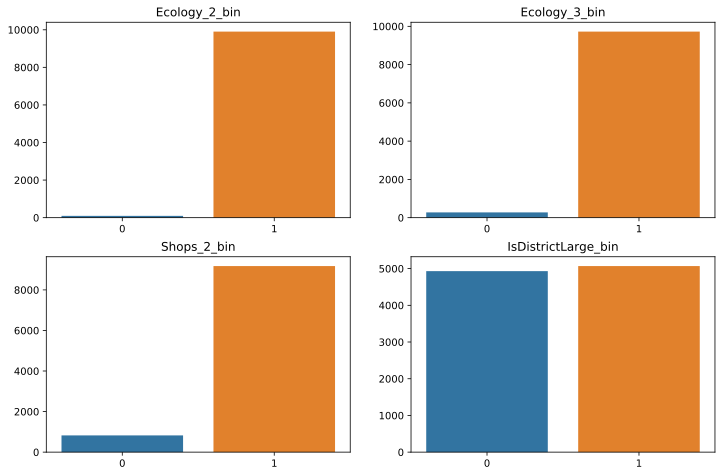

In [1044]:
plt.figure(figsize = (12,12))

for i, colname in enumerate(df_bin_features.columns):
    counts = df_bin_features[colname].value_counts()
    
    plt.subplot(3,2,i+1)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

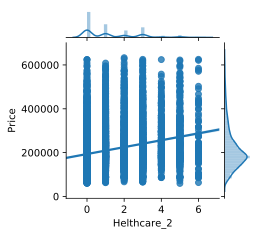

In [1045]:
grid = sns.jointplot(train_df['Helthcare_2'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(3)
grid.fig.set_figheight(3)

plt.show()

**MedPrice**

In [1046]:
med_price = train_df.groupby(['DistrictId','HouseYear','HouseFloor', 'Floor','Rooms','KitchenSquare'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'MedPrice'})

med_price.head()

DistrictId  HouseYear  HouseFloor  Floor  Rooms  KitchenSquare  \
0          0       1959         5.0      4    2.0            6.0   
1          0       1960         8.0      4    3.0            8.0   
2          0       1961         5.0      1    1.0            3.0   
3          0       1961         5.0      5    1.0            5.0   
4          0       1962         5.0      2    1.0            3.0   

        MedPrice  
0  221660.251771  
1  339228.823764  
2   88871.750230  
3  142799.434052  
4  102395.788856

In [1047]:
train_df = train_df.merge(med_price, on=['DistrictId','HouseYear','HouseFloor','Floor','Rooms','KitchenSquare'], how='left')
train_df.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  47.981561   29.442751            6.0      7   
1  15053         41    3.0  65.683640   40.049543            8.0      7   
2   4765         53    2.0  44.947953   29.197612            3.0      8   
3   5809         58    2.0  53.352981   52.731512            9.0      8   
4  10783         99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1  ... Helthcare_2 Shops_1  Shops_2  \
0         9.0       1969   0.089040  ...           0      11        B   
1         9.0       1978   0.000070  ...           1      16        B   
2        12.0       1968   0.049637  ...           1       3        B   
3        17.0       1977   0.437885  ...           0       5        B   
4        12.0       1976   0.012339  ...           2       4        B   

           Price  Ecology_2_bin  Ecology_3_bin  Shops_2_bin  DistrictSize  \
0  184966.930730              1              1            1            22   
1  300009.450063              1              1            1            87   
2  220925.908524              1              1            1           174   
3  175616.227217              1              1            1           179   
4  150226.531644              1              1            1            97   

  IsDistrictLarge_bin       MedPrice  
0                   0  184966.930730  
1                   0  300009.450063  
2                   1  220925.908524  
3                   1  175616.227217  
4                   0  150226.531644  

[5 rows x 26 columns]

In [1048]:
test_df = test_df.merge(med_price, on=['DistrictId','HouseYear','HouseFloor','Floor','Rooms','KitchenSquare'], how='left')

**Сохранение подготовленных датасетов**

In [1049]:
PREPARED_TRAIN_DATASET_PATH = 'prepared_train.csv'
train_df.to_csv(PREPARED_TRAIN_DATASET_PATH, index=False, encoding='utf-8')
PREPARED_TEST_DATASET_PATH = 'prepared_test.csv'
train_df.to_csv(PREPARED_TEST_DATASET_PATH, index=False, encoding='utf-8')

### Матрица корелляций

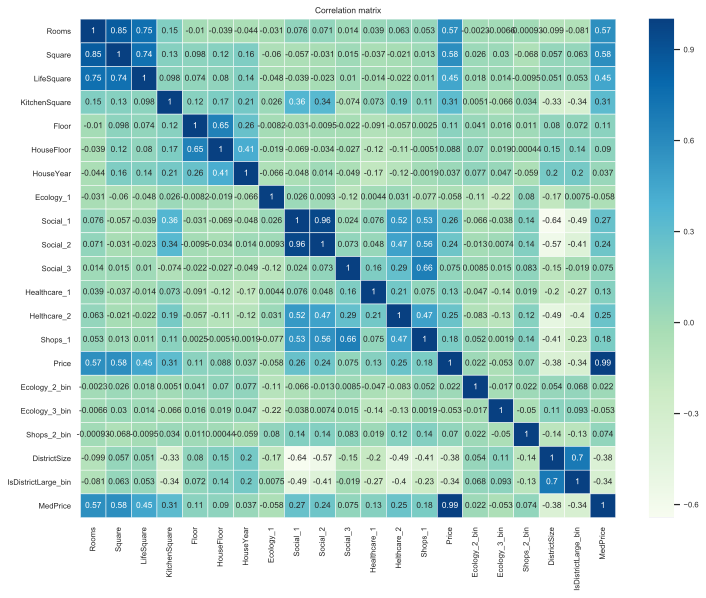

In [1050]:
plt.figure(figsize = (12,9))

sns.set(font_scale=0.7)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')
plt.title('Correlation matrix')
plt.savefig('Correlation matrix_.png')
plt.show()

In [1051]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge_bin',
 'MedPrice']

In [1052]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['MedPrice']

target_name = 'Price'

### Разбиение train выборки на train и test

In [1053]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [1054]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Построение модели

**Обучение и оценка модели**

In [1055]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=21, verbose=0, warm_start=False)

**Отложенная выборка**

Train R2:	0.998
Test R2:	0.986


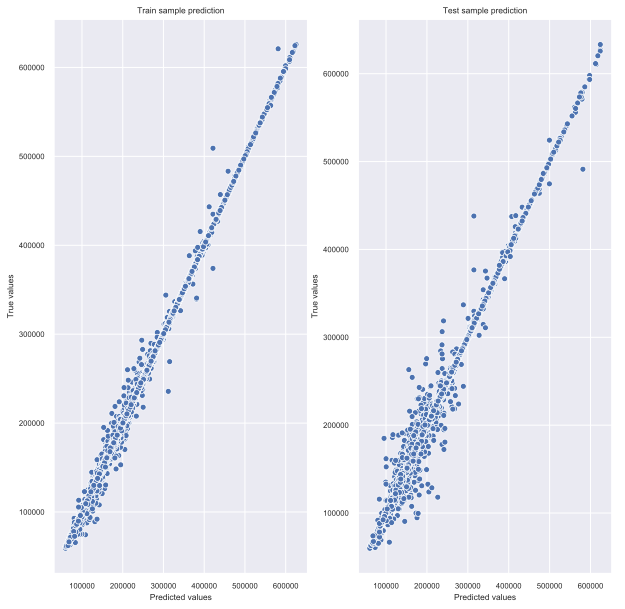

In [1056]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка**

In [1057]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=5))
cv_score

array([0.98455628, 0.98759212, 0.987685  , 0.98024179, 0.98708009])

In [1058]:
cv_score.mean()

0.9854310569099398

**Важность признаков**

In [1059]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
16       MedPrice    0.992029
1          Square    0.003503
2      LifeSquare    0.000834
10       Social_2    0.000755
5      HouseFloor    0.000649
4           Floor    0.000637
7       Ecology_1    0.000361
12   Healthcare_1    0.000315
6       HouseYear    0.000170
11       Social_3    0.000164
14        Shops_1    0.000163
0           Rooms    0.000120
15    Shops_2_bin    0.000120
3   KitchenSquare    0.000112
13    Helthcare_2    0.000043
9   Ecology_3_bin    0.000014
8   Ecology_2_bin    0.000011

**Подбор гиперпараметров**

In [1060]:
params_rf = {'n_estimators':[350,375,400], 
          'max_depth':[3,5,7]}

gs_rf = GridSearchCV(rf_model, params_rf, scoring='r2', cv=KFold(n_splits=5, random_state=5, shuffle=True), n_jobs=-1)
gs_rf.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=5, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=21, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [350, 375, 400], 'max_depth': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [1062]:
gs_rf.best_params_

{'max_depth': 5, 'n_estimators': 400}

In [1063]:
gs_rf.best_score_

0.9891542821668025

**Построение модели с подобранными гиперпараметрами**

In [1064]:
rf_model = RandomForestRegressor(random_state=21, max_depth=5,n_estimators=400)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=False, random_state=21, verbose=0, warm_start=False)

Train R2:	0.99
Test R2:	0.99


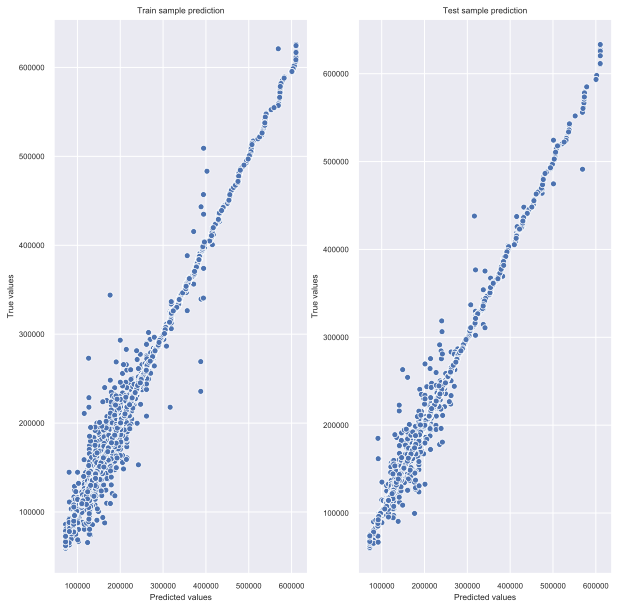

In [1065]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [1067]:
test_df.head()

Id DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038         35    2.0  49.882643   33.432782            6.0      6   
1  15053         41    2.0  69.263183   32.832574            3.0      1   
2   4765         53    1.0  40.117689   15.948246            6.0      2   
3   5809         58    2.0  73.046609   51.940842            9.0     22   
4  10783         99    1.0  47.527111   43.387569            3.0     17   

   HouseFloor  HouseYear  Ecology_1  ... Healthcare_1 Helthcare_2  Shops_1  \
0        14.0       1972   0.310199  ...        900.0           0        0   
1         1.0       1977   0.075779  ...        900.0           0        2   
2         5.0       1909   0.000000  ...       4702.0           5        5   
3        22.0       2007   0.101872  ...        900.0           3        3   
4        17.0       2017   0.072158  ...        900.0           0        0   

   Shops_2  Ecology_2_bin  Ecology_3_bin  Shops_2_bin  DistrictSize  \
0        B              1              1            1             8   
1        B              1              1            1            39   
2        B              1              1            1            76   
3        B              1              1            1            85   
4        A              1              1            0            44   

  IsDistrictLarge_bin  MedPrice  
0                   0       NaN  
1                   0       NaN  
2                   0       NaN  
3                   0       NaN  
4                   0       NaN  

[5 rows x 25 columns]

In [1070]:
test_df.loc[~test_df['MedPrice'].isnull()]

Id DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
14    10953         27    1.0   37.555197   21.802247            3.0      1   
21    11935         27    1.0   44.878767   21.802247            3.0      1   
43      175         23    1.0   37.484057   40.593036            3.0      4   
46     1821         23    1.0   42.899569   21.802247            3.0      4   
70    10362         27    2.0   52.449057   52.798349            3.0     17   
71     2136         74    2.0   55.849965    4.188395            3.0      1   
98     9753         23    1.0   43.286141   21.802247            3.0     12   
127   10337         28    2.0   43.608366   29.310620            5.0      2   
134   12613          6    1.0   44.900715   21.802247            3.0     15   
153    9870         62    3.0  105.351051    5.589869            3.0      1   
173    5790         27    2.0   65.998855   64.099759            3.0      9   
182   15527         52    2.0   66.099968   32.832574            3.0     14   
217    5540         27    2.0   66.509248   32.832574            3.0     13   
231    2540          6    1.0   48.835269   21.802247            3.0      1   
239    3351          1    2.0   64.226922   32.832574            3.0     16   
284    8418         23    1.0   38.870525   41.172814            3.0      1   
285    7434         27    2.0   64.297449   32.832574            3.0      8   
301   14374         62    2.0   54.236730   32.832574            3.0     13   
304    5176          1    3.0   87.871716   47.225105            3.0      1   
318   12382         23    2.0   67.580352   32.832574            3.0      1   
323   10144         30    2.0   54.510409   32.832574            3.0      4   
355    6356          6    2.0   73.695261   32.832574            3.0     17   
369      61          1    2.0   70.894808   32.832574            3.0      1   
378   15443          1    2.0   52.917817   32.832574            3.0      3   
393   14073         23    1.0   47.989727   21.802247            3.0      4   
397    6781         58    1.0   37.927539   20.801919            6.0      9   
447     351          1    1.0   35.854782   21.802247            3.0      1   
470    8572         23    2.0   67.690675   32.832574            3.0      9   
498   12796          6    2.0   78.546545   32.832574            3.0     15   
531   13534         58    2.0   60.098875   32.832574            3.0     17   
...     ...        ...    ...         ...         ...            ...    ...   
4584   5583         27    1.0   38.057566   21.802247            3.0      3   
4590   4859         27    3.0   89.582486   47.225105            3.0      1   
4594   4315         85    3.0   66.641394   48.280790            6.0      9   
4614   9673          1    1.0   40.983889   21.802247            3.0     12   
4615   6531         23    1.0   49.180145   21.802247            3.0      1   
4618  10661          6    2.0   65.632832   32.832574            3.0     17   
4632  13507          6    2.0   67.357668   32.832574            3.0     14   
4639  13523         23    2.0   55.849965   32.832574            3.0      7   
4649   5528          6    1.0   49.943189   21.802247            3.0      9   
4661   7305         30    1.0   37.427076   21.802247            3.0     11   
4676  16092         62    1.0   35.344501   21.802247            3.0      7   
4718   5362         58    2.0   76.607538    2.820279            3.0      1   
4774   9554         62    3.0   79.172401   47.225105            3.0     10   
4782  13899          1    1.0   41.681791   21.802247            3.0      5   
4801  12785         74    2.0   67.355857   32.832574            3.0      4   
4803  12205         30    2.0   53.758040   32.832574            3.0      5   
4817   4238         27    1.0   43.042989   21.802247            3.0     15   
4820  15715          1    1.0   42.359964   21.802247            3.0      7   
4825   9951          1    2.0   54.997400   32.832574      

In [ ]:
X_train = train_df[feature_names + new_feature_names]
y_train = train_df[target_name]
X_test = test_df[feature_names + new_feature_names]